In [22]:
library(SingleCellExperiment)
library(scater)
library(limma)
options(stringsAsFactors = FALSE)
library(data.table)
library(scran)

In [23]:
# Set the raw data and save/load it
umi <- NULL
generateit = FALSE

genes_of_interest <- c(
    "Eomes", "Brachyury", "Mesp1",                # meso
    "Pou5f1", "nanog",                            # pluripotent
    "Sox1", "Sox2", "Pou3f1", "zfp462", "slc7a3") # neuroectoderm

if (is.null(umi) && generateit){
    counts_raw <- read.table("/extra/sebastian_arnolds/analysis/trim/counts_matrix.tsv",sep="\t")
    barcodes_vector <- as.vector(
        read.table("/extra/sebastian_arnolds/analysis/celseq_barcodes_raw_all.txt")[, 1]
    )
    count_matrix <- as.matrix(counts_raw[, barcodes_vector])

    # Change labels for genes of interest
    name_map = list(
        ENSMUSG00000062327 = "Brachyury",
        ENSMUSG00000032446 = "Eomes",
        ENSMUSG00000030544 = "Mesp1",
        ENSMUSG00000024406 = "Pou5f1",
        ENSMUSG00000012396 = "nanog",
        ENSMUSG00000096014 = "Sox1",
        ENSMUSG00000074637 = "Sox2",
        ENSMUSG00000090125 = "Pou3f1",
        ENSMUSG00000060206 = "zfp462",
        ENSMUSG00000031297 = "slc7a3"
    )

    for (i in 1:length(name_map)){
        old_gene_name <- names(name_map[i])
        new_gene_name <- name_map[[i]]
        #message(old_gene_name, "→", new_gene_name)
        rownames(count_matrix)[which(rownames(count_matrix) == old_gene_name)] <- new_gene_name
    }

    saveRDS(count_matrix, "seurat_matrix.rds")
    umi <- count_matrix

} else {
    umi <- as.matrix(readRDS("seurat_matrix.rds"))
}

# Create SCE and annotate
sce <- SingleCellExperiment(assays = list(counts = umi))

# Assign known/related groups
is.meso <- rownames(sce) %in% c("Eomes", "Brachyury", "Mesp1")
is.pluri <- rownames(sce) %in% c("Pou5f1", "nanog")
is.neuro <- rownames(sce) %in% c("Sox1", "Sox2", "Pou3f1", "zfp462", "slc7a3")

rowData(sce)$is_mesoderm <- is.meso
rowData(sce)$is_pluripotenz <- is.pluri
rowData(sce)$is_neuroectoderm <- is.neuro

# Assign known/related cell batches
colData(sce)$plate_number <- c(rep("plate1", 96), rep("plate2", 96)) 

#head(counts(sce))

#sce <- getBMFeatureAnnos(
#    sce, 
#    filters = "ensembl_gene_id", 
#    attributes = c("ensembl_gene_id", "external_gene_name"), 
#    feature_symbol = "mgi_symbol",
#    feature_id = "ensembl_gene_id",
#    biomart = "ENSEMBL_MART_ENSEMBL",
#    dataset = "mmusculus_gene_ensembl", 
#    host = "www.ensembl.org"
#)

message(dim(sce)[1], " genes x ", dim(sce)[2], " cells. (", 
        length(unique(colnames(sce))), ") unique barcodes.")

21070 genes x 192 cells. (192) unique barcodes.


In [48]:
# Different filtering strategies
# - Remove genes with transcripts not found in any cell
filter_g0c0 <- rowSums(counts(sce) > 0) > 0
# - Remove genes with less than 1 transcript in at least 2 cells
filter_g1c2 <- rowSums(counts(sce) > 1) > 2
# - Remove genes with less than 2 transcripts in at least 3 cells
filter_g2c3 <- rowSums(counts(sce) > 2) > 3
# - Remove genes with less than 5 transcripts in at least 5 cells
filter_g5c5 <- rowSums(counts(sce) > 5) > 5
# - Remove genes with less than 10 transcripts in at least 2 cells
filter_g10c2 <- rowSums(counts(sce) > 10) > 2

tableau <- (
    rbind(
    c("All", "g > 0 in c > 0",  "g > 1 in c > 2", "g > 2 in c > 3", "g > 5 in c < 5", "g > 10 in c < 2"),
    c(length(sce), length(sce[filter_g0c0,]), length(sce[filter_g1c2,]), length(sce[filter_g2c3,]), length(sce[filter_g5c5,]), length(sce[filter_g10c2,]))
))
rownames(tableau) <- c("Category", "Genes")

tableau


# find out gene annotation

# Apply filters
sce <- calculateQCMetrics(sce)
sce_g0c0 <- calculateQCMetrics(sce[filter_g0c0,])
sce_g1c2 <- calculateQCMetrics(sce[filter_g1c2,])
sce_g2c3 <- calculateQCMetrics(sce[filter_g2c3,])
sce_g5c5 <- calculateQCMetrics(sce[filter_g5c5,])
sce_g10c2 <- calculateQCMetrics(sce[filter_g10c2,])


Category,All,g > 0 in c > 0,g > 1 in c > 2,g > 2 in c > 3,g > 5 in c < 5,g > 10 in c < 2
Genes,21070,20662,9918,7137,3290,1949


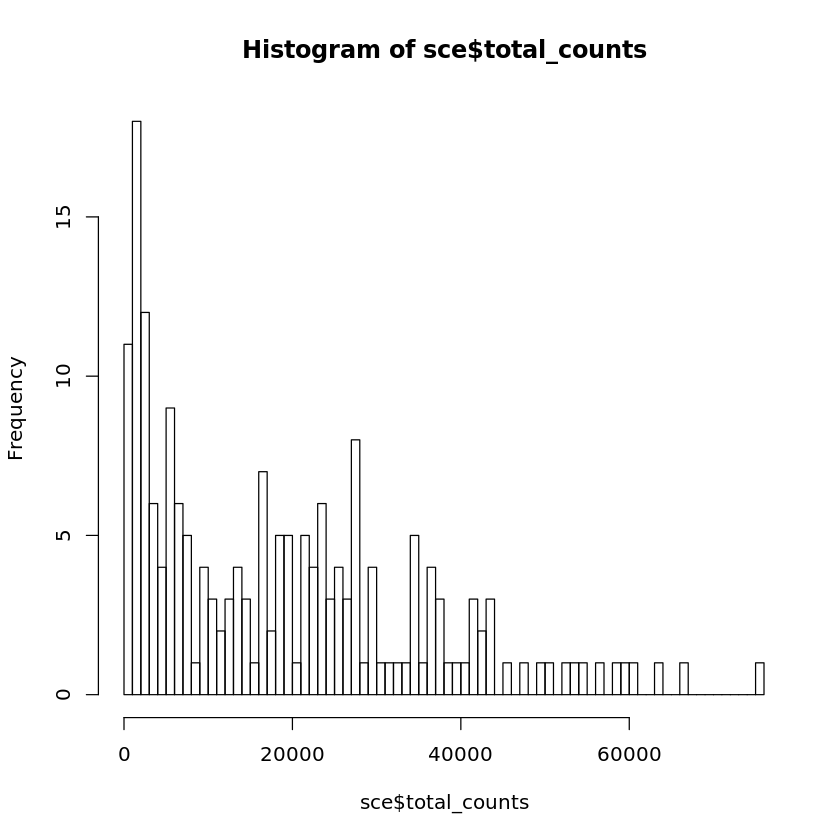

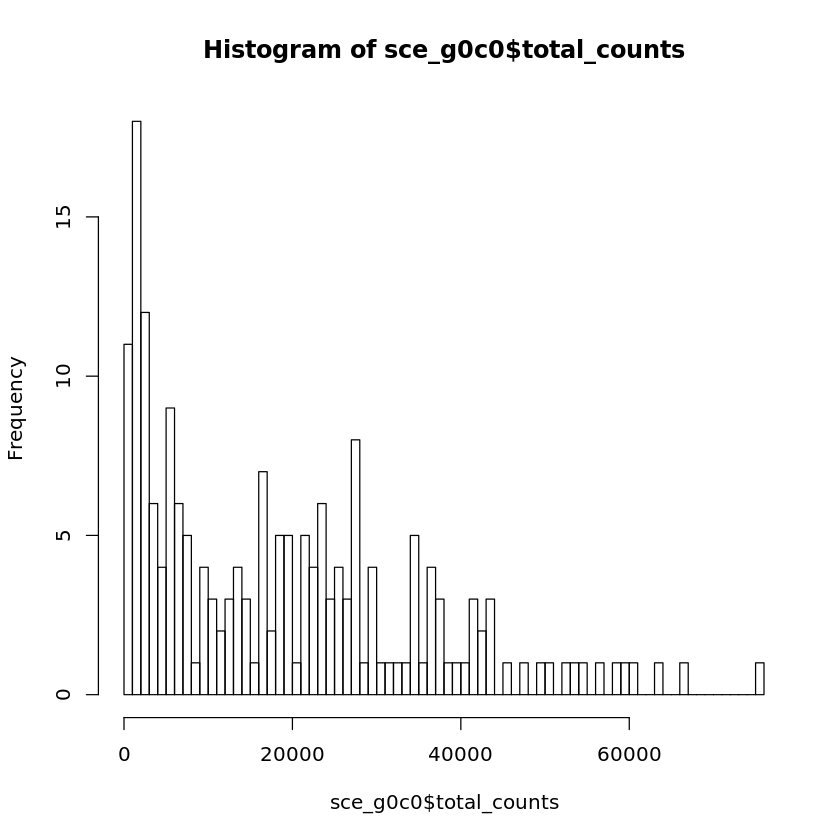

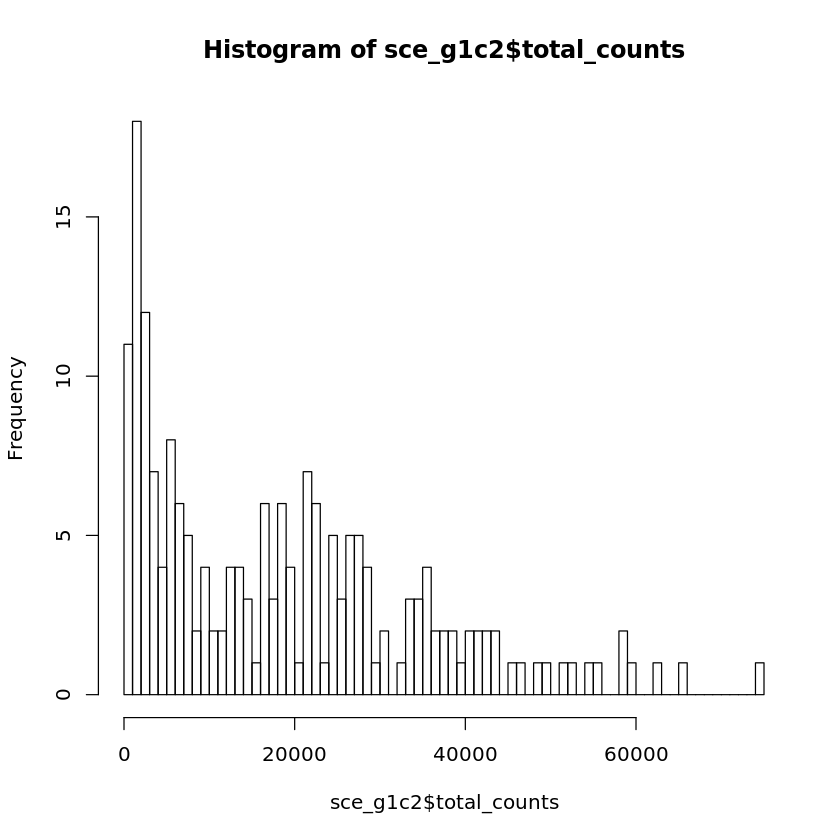

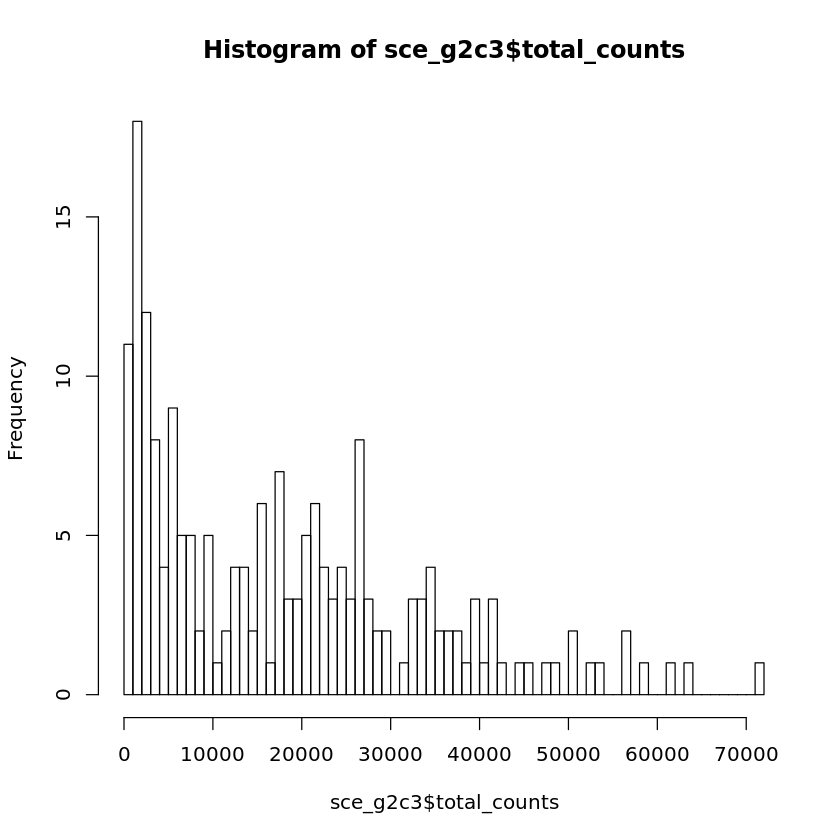

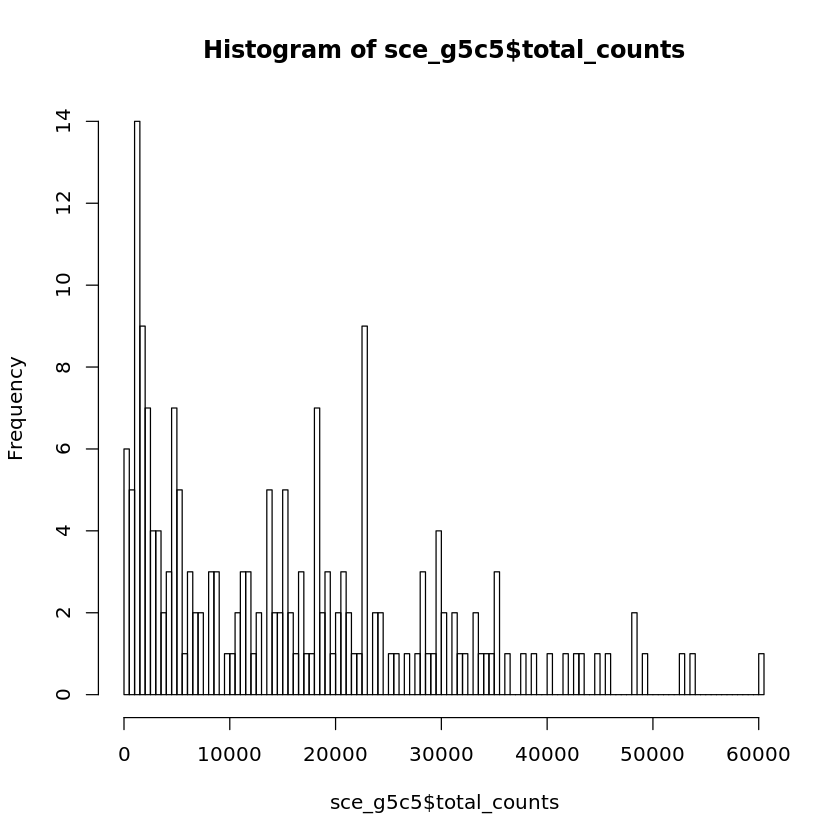

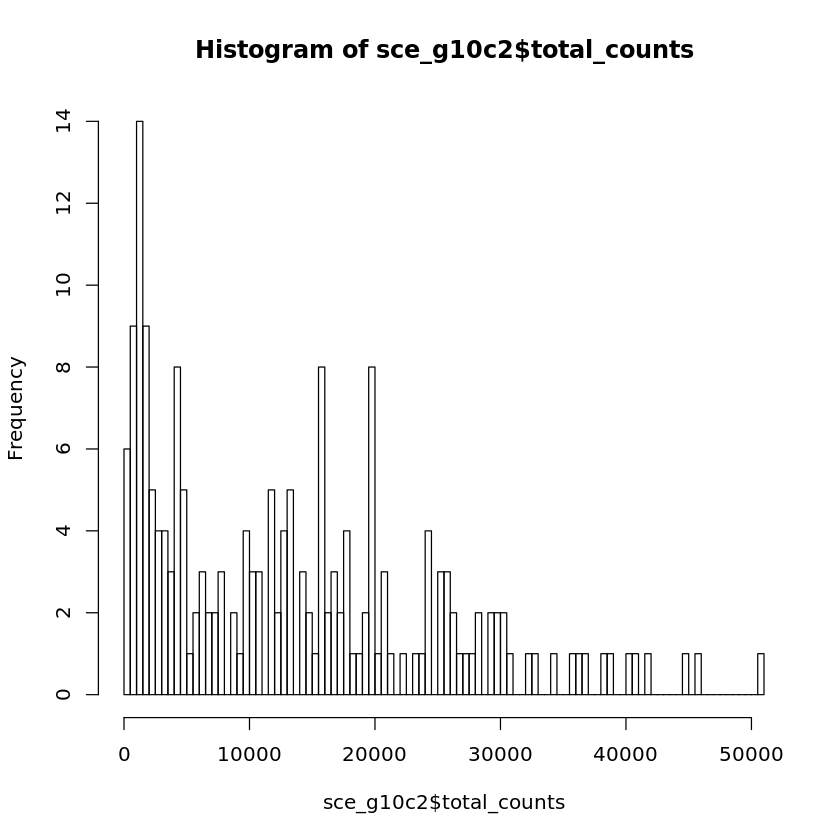

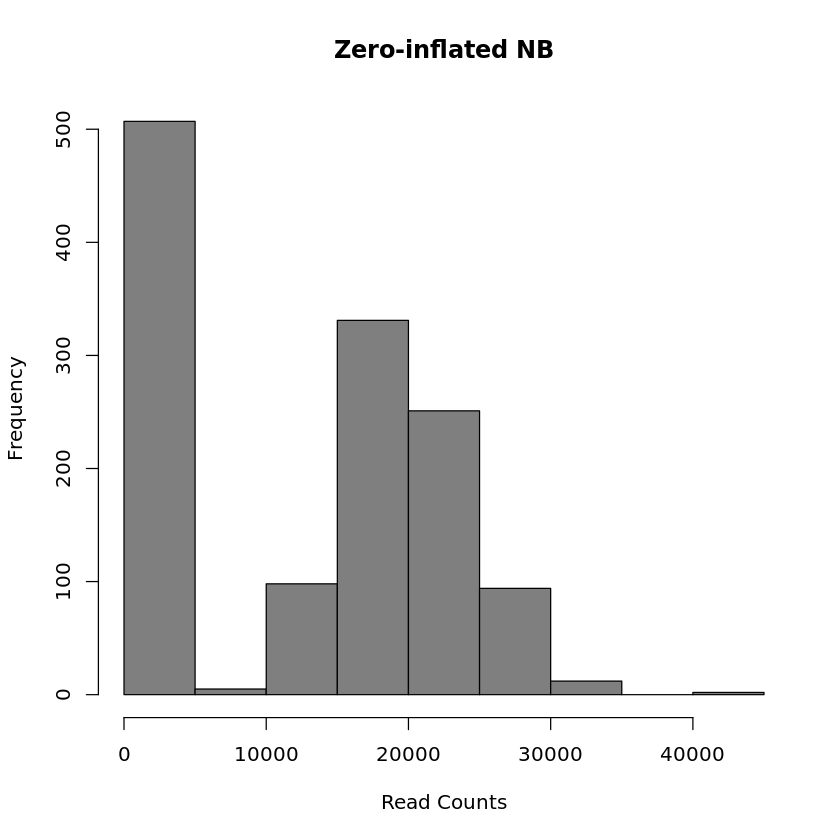

In [51]:
# Compare histograms
hist(sce$total_counts, breaks=100)
hist(sce_g0c0$total_counts, breaks=100, add=F)
hist(sce_g1c2$total_counts, breaks=100, add=F)
hist(sce_g2c3$total_counts, breaks=100, add=F)
hist(sce_g5c5$total_counts, breaks=100, add=F)
hist(sce_g10c2$total_counts, breaks=100, add=F)

counts <- rnbinom(1300, mu = 20000, size = 20)
counts[runif(100) < 0.5] <- 0
hist(counts, col = "grey50", xlab = "Read Counts", main = "Zero-inflated NB")

In [55]:
# dim(sce[rowSums(sce) > 8000, ])

ERROR: Error in rowSums(sce): 'x' must be an array of at least two dimensions


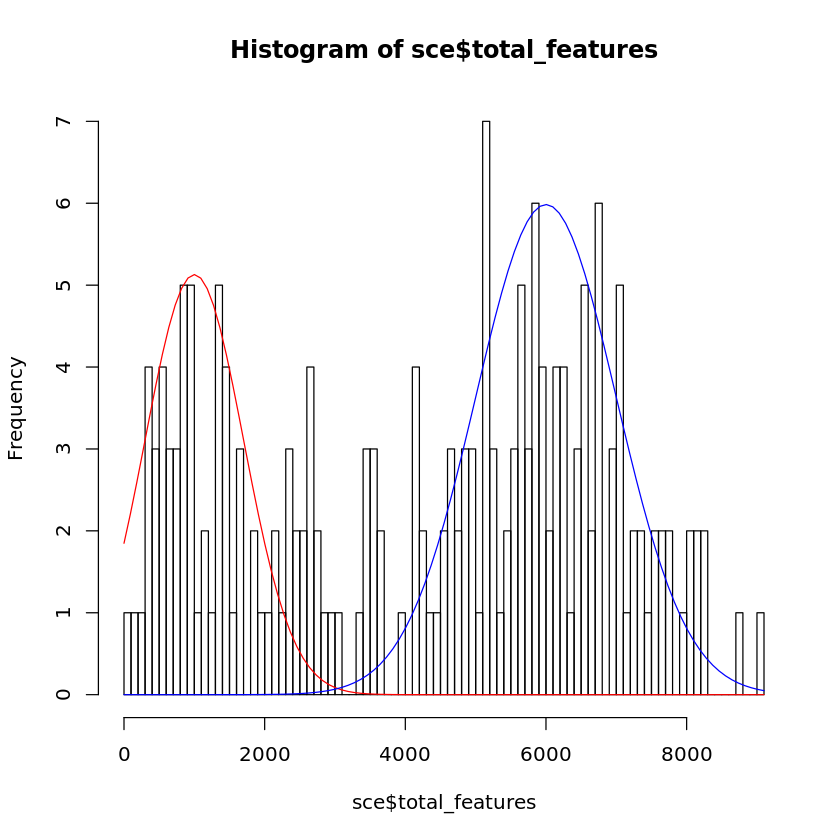

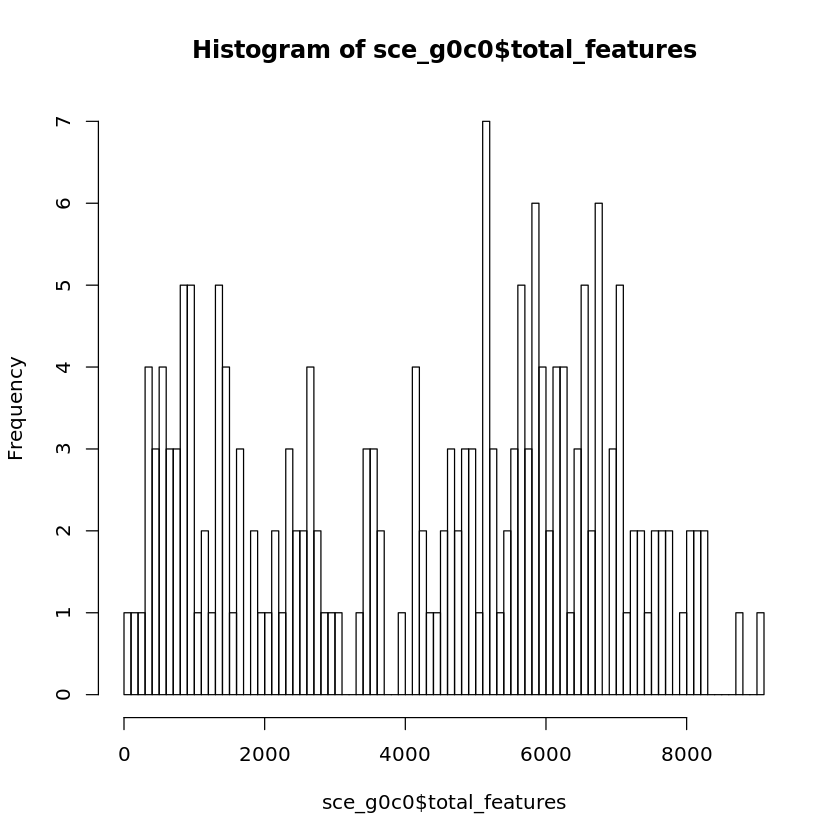

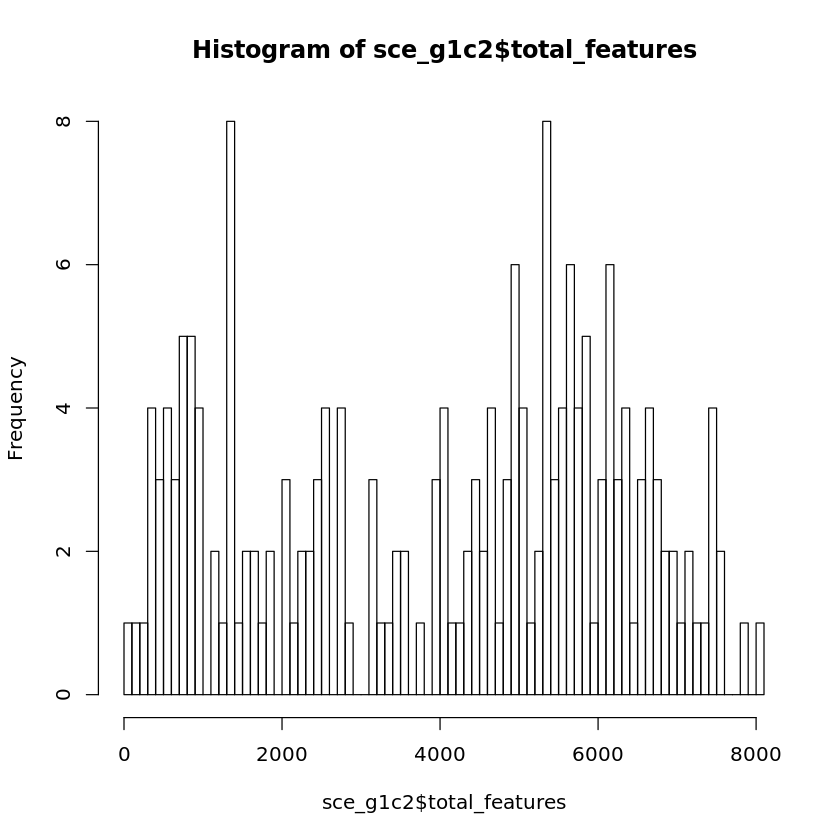

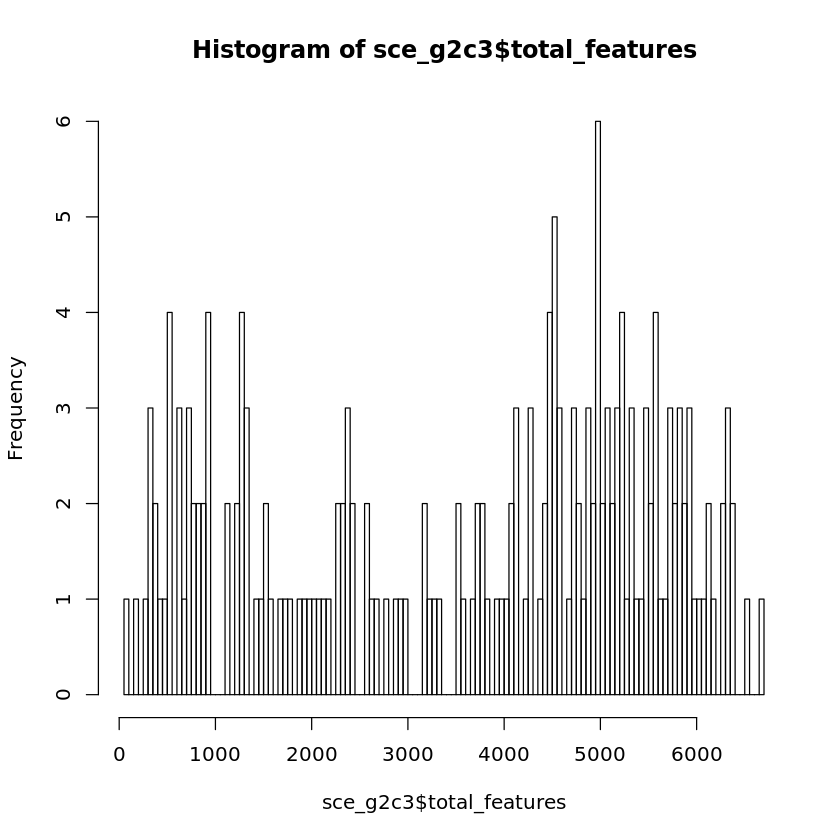

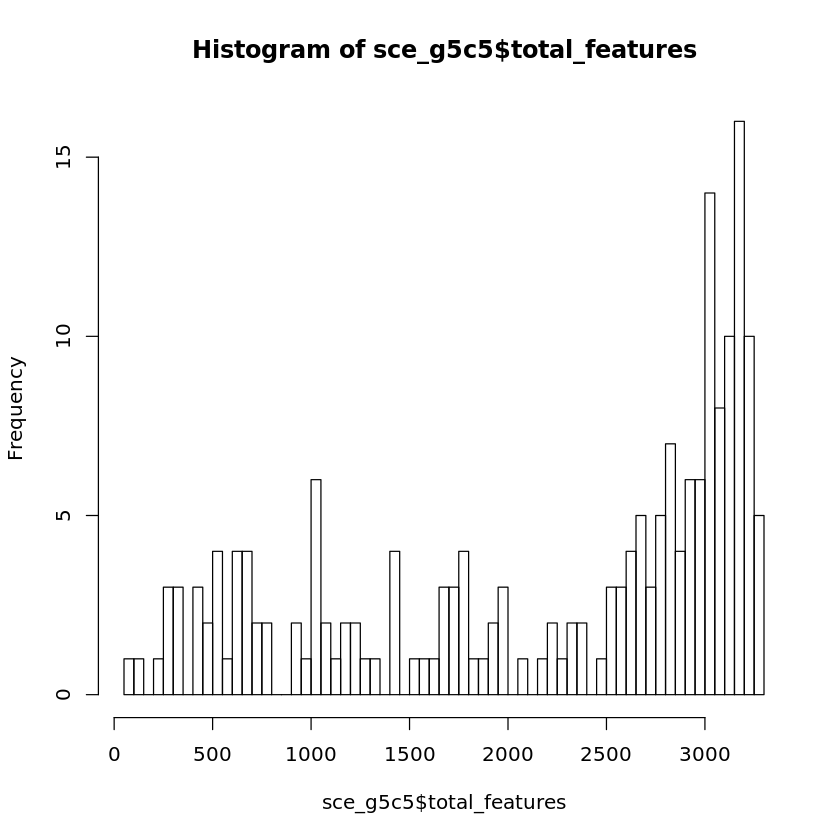

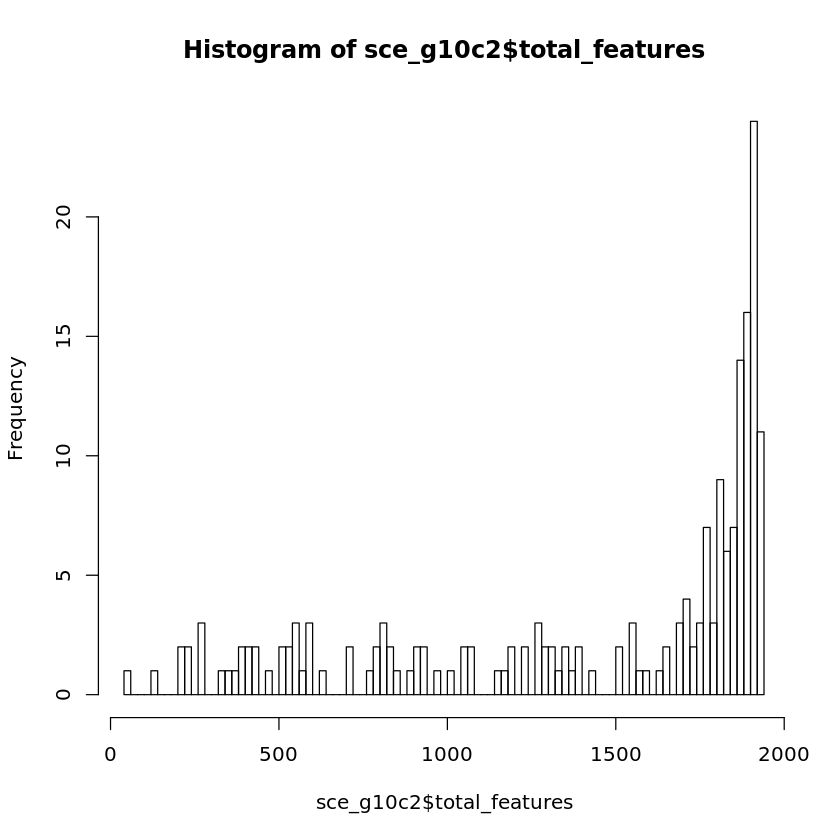

In [26]:
hist(sce$total_features, breaks=100)
curve(dnorm(x, 1000, 700) * 9000, col = "red", add = TRUE)
curve(dnorm(x, 6000, 1000) * 15000, col = "blue", add = TRUE)

hist(sce_g0c0$total_features, breaks=100, add=F)
hist(sce_g1c2$total_features, breaks=100, add=F)
hist(sce_g2c3$total_features, breaks=100, add=F)
hist(sce_g5c5$total_features, breaks=100, add=F)
hist(sce_g10c2$total_features, breaks=100, add=F)


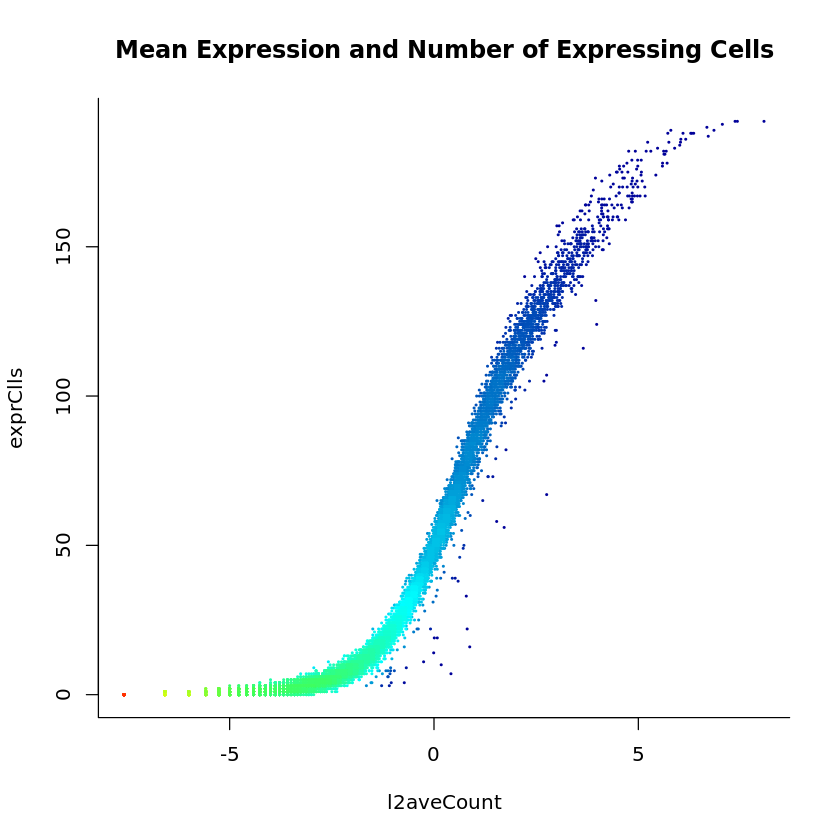

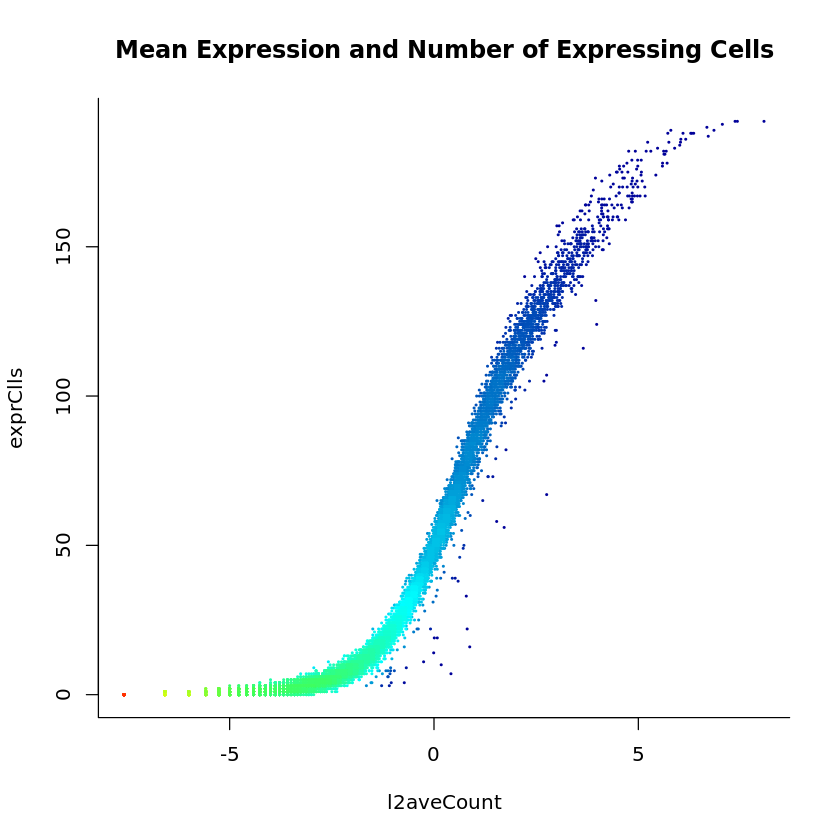

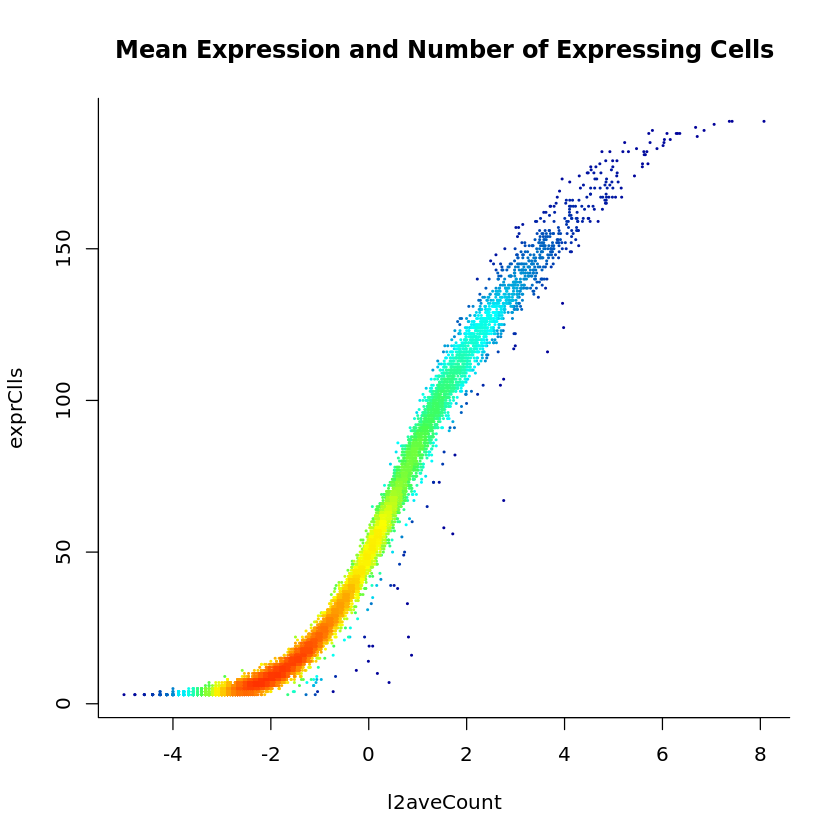

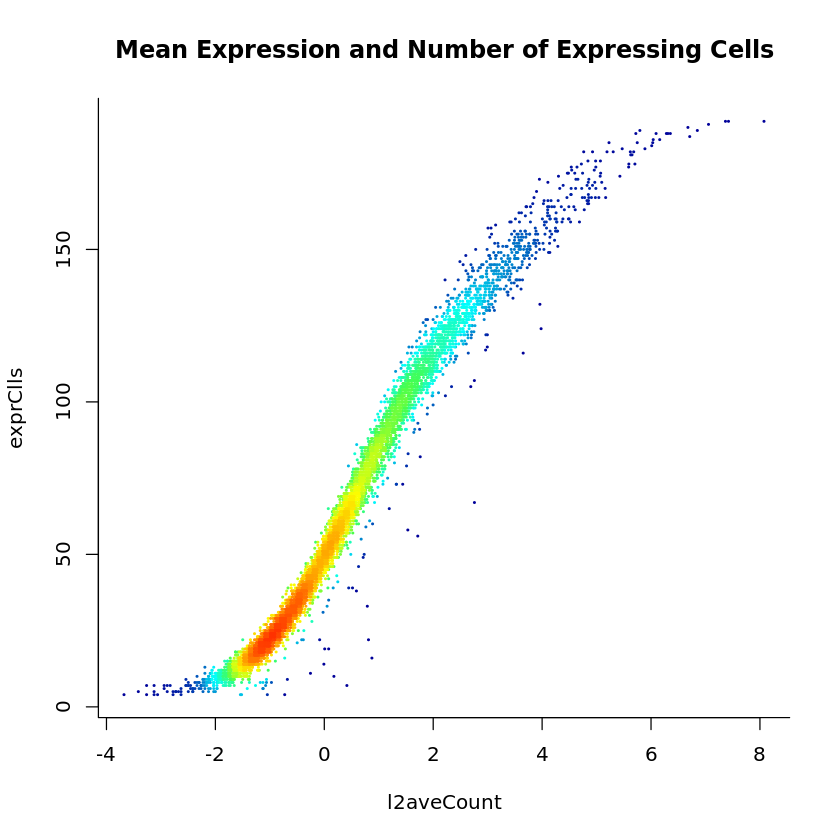

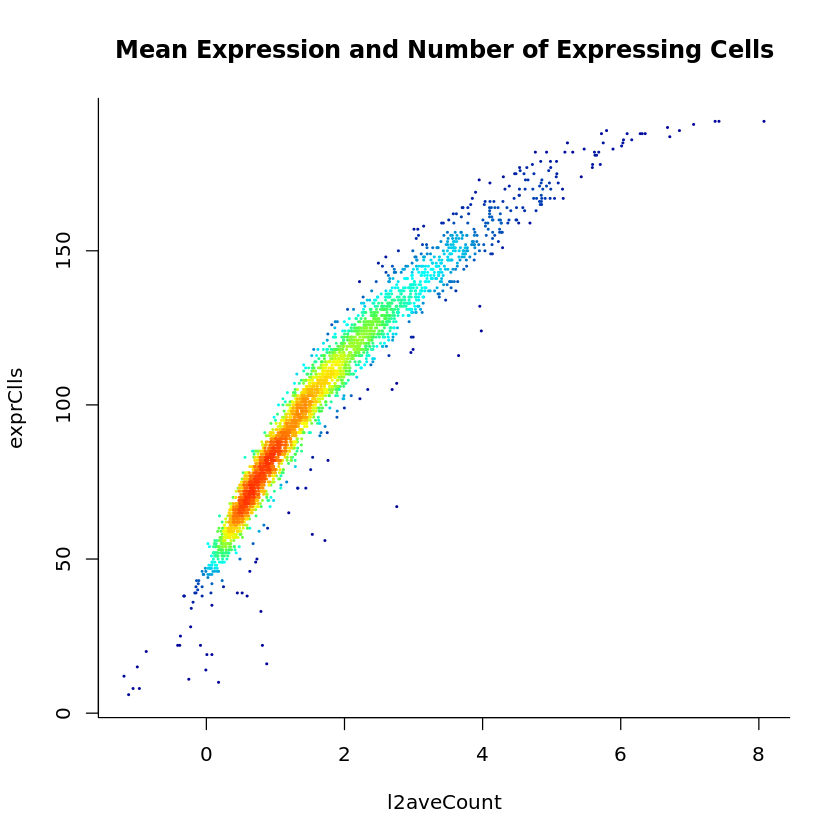

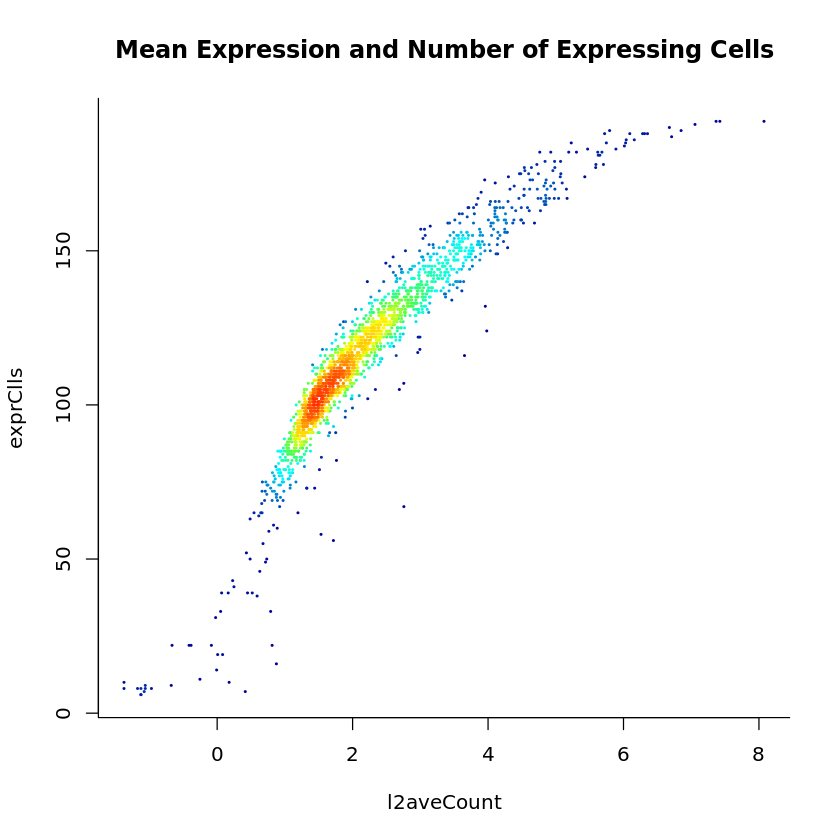

In [49]:
meanExpr <- function(data){
    gene_averages = rowMeans(counts(data))
    # gene_medians = rowMedians(counts(sce)),  ## median would not highlight extremities

    expr_cells <- apply(counts(data), 1, function(x) {sum(x > 1)})

    df <- data.frame(
      l2aveCount = log2(gene_averages), 
      exprClls = expr_cells
    )
    arr <- densCols(df$exprClls, df$l2aveCount, 
                    colramp = colorRampPalette(c("black", "white")))
    df$dens <- col2rgb(arr)[1, ] + 1L
    cols <-  colorRampPalette(c("#000099", "#00FEFF", "#45FE4F", "#FCFF00", 
                            "#FF9400", "#FF3100"))(256)
    df$col <- cols[df$dens]
    plot(
        exprClls ~ l2aveCount, data = df[order(df$dens), ],
        pch = 20, col = col,
        cex = 0.3, bty = "l",
        main = "Mean Expression and Number of Expressing Cells"
        #xlim = c(-8,2), ylim = c(0,100)
    )
}

meanExpr(sce)
meanExpr(sce_g0c0)
meanExpr(sce_g1c2)
meanExpr(sce_g2c3)
meanExpr(sce_g5c5)
meanExpr(sce_g10c2)

In [42]:
nsce.raw <- copy(sce_g1c2)
nsce.cpm <- copy(sce_g1c2)
nsce.sf <- copy(sce_g1c2)
nsce.tmm <- copy(sce_g1c2)
nsce.scran <- copy(sce_g1c2)

nsce.raw$namer = "RAW"
nsce.cpm$namer = "CPM"
nsce.tmm$namer = "TMM"
nsce.scran$namer = "scran"
nsce.sf$namer = "SF"

logcounts(nsce.raw) <- log2(counts(nsce.raw) + 1)
logcounts(nsce.cpm) <- log2(calculateCPM(nsce.cpm, use.size.factors = FALSE) + 1)
nsce.sf  <- normaliseExprs(nsce.sf, method = "RLE", return_log = TRUE, return_norm_as_exprs = TRUE)
nsce.tmm <- normaliseExprs(nsce.tmm, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)

# scran CPM norm
qclust <- quickCluster(nsce.scran, min.size = 3)
nsce.scran <- computeSumFactors(nsce.scran, sizes = 10, clusters = qclust)
nsce.scran <- normalize(nsce.scran)


Warning message in .computeSumFactors(assay(x, i = assay.type), subset.row = subset.row, :
“encountered negative size factor estimates”

A comparison of the various normalisation method


,AGTGTC,ACCATG,GAGTGA,CACTCA,CATGTC,ACAGGA,GTACCA,ACAGAC,ACGTTG
RAW,0,2.000000,1.584963,1.584963,2.584963,3.000000,2.807355,1.584963,0
CPM,0,1.458341,1.601534,2.074620,2.152032,2.134122,2.367362,2.254999,0
SF,0,1.501720,1.559597,1.450738,2.045065,2.500167,2.408578,1.364187,0
TMM,0,1.542243,1.523442,1.942360,2.254638,2.254752,2.410686,1.927415,0
SCRAN,0,1.433213,1.555510,2.169861,2.068058,2.031981,2.402596,2.219020,0


Warning message:
“Removed 192 rows containing missing values (geom_segment).”Warning message:
“Removed 192 rows containing missing values (geom_segment).”Warning message:
“Removed 192 rows containing missing values (geom_segment).”Warning message:
“Removed 192 rows containing missing values (geom_point).”

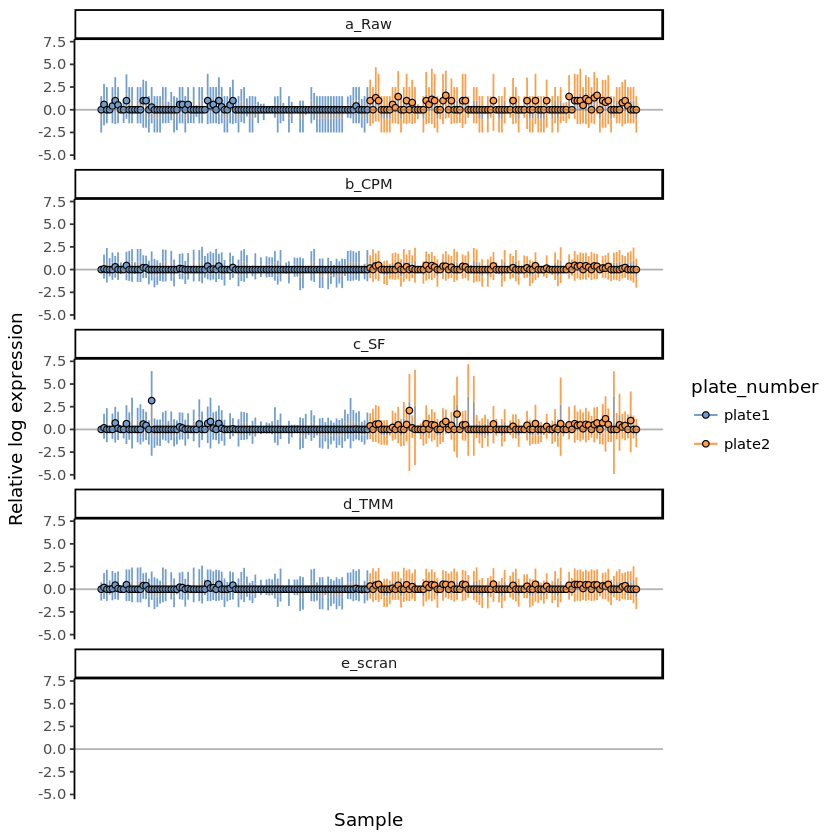

In [43]:
message("A comparison of the various normalisation method")

tableau <- rbind(
    head(logcounts(nsce.raw), 1),
    head(logcounts(nsce.cpm), 1),
    head(logcounts(nsce.sf), 1),
    head(logcounts(nsce.tmm), 1),
    head(logcounts(nsce.scran), 1)
)
rownames(tableau) <- c("RAW", "CPM", "SF", "TMM", "SCRAN")
tableau[,1:9]

plotRLE(
    sce_g1c2,  # not used
    exprs_mats = list(
        a_Raw   = logcounts(nsce.raw),
        b_CPM   = logcounts(nsce.cpm),
        c_SF    = logcounts(nsce.sf),
        d_TMM   = logcounts(nsce.tmm),
        e_scran = logcounts(nsce.scran)
    ),
    exprs_logged = c(TRUE, TRUE, TRUE, TRUE, TRUE),
    colour_by = "plate_number",
    order_by_color = FALSE
)

# Proceeding with TMM (fast, good)

In [27]:
#logcounts(sce) <- log2(calculateCPM(sce_g0c0, use.size.factors = FALSE) + 1)
#logcounts(sce_g1c2) <- log2(calculateCPM(sce_g1c2, use.size.factors = FALSE) + 1)
#logcounts(sce_g2c3) <- log2(calculateCPM(sce_g2c3, use.size.factors = FALSE) + 1)
#logcounts(sce_g5c5) <- log2(calculateCPM(sce_g5c5, use.size.factors = FALSE) + 1)
#logcounts(sce_g10c2) <- log2(calculateCPM(sce_g10c2, use.size.factors = FALSE) + 1)

sce <- normaliseExprs(sce, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)
sce_g0c0 <- normaliseExprs(sce_g0c0, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)
sce_g1c2 <- normaliseExprs(sce_g1c2, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)
sce_g2c3 <- normaliseExprs(sce_g2c3, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)
sce_g5c5 <- normaliseExprs(sce_g5c5, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)
sce_g10c2 <- normaliseExprs(sce_g10c2, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)


#for (mat in c(sce, sce_g0c0, sce_g1c2, sce_g2c3, sce_g5c5, sce_g10c2)){
#    logcounts(mat) <- log2(calculateCPM(mat, use.size.factors = FALSE) + 1)
#    print(assays(mat))
#    print(head(logcounts(mat)))
#}

head(logcounts(sce_g0c0))
#head(logcounts(sce))


,AGTGTC,ACCATG,GAGTGA,CACTCA,CATGTC,ACAGGA,GTACCA,ACAGAC,ACGTTG,ACCAAC,⋯,AGCGAA,GGTTAG,GATTGC,CGTTCA,ATCCGA,GCATTC,CCTGAA,GGAATC,TCAACG,AACACC
ENSMUSG00000000001,0,1.575774,1.5086036,1.909221,2.233839,2.3111893,2.4404345,2.020048,0,2.2313582,⋯,2.943197,1.733143,2.024144,2.5550721,2.6377799,2.797249,2.160891,2.2663030,1.914052,0.000000
ENSMUSG00000000028,0,0.000000,0.9431131,0.000000,0.000000,0.0000000,0.7974353,0.000000,0,0.8649525,⋯,0.000000,0.000000,0.000000,0.8582421,0.7250575,1.131080,1.624403,0.0000000,0.000000,0.000000
ENSMUSG00000000031,0,0.000000,0.0000000,0.000000,1.688093,1.0923853,0.7974353,1.337989,0,0.0000000,⋯,3.464238,0.000000,1.341276,7.0953156,0.0000000,1.757217,2.712608,1.7165662,7.206907,2.646454
ENSMUSG00000000037,0,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.0000000,0.000000,0,0.0000000,⋯,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000
ENSMUSG00000000056,0,0.000000,0.0000000,0.000000,0.000000,0.6472053,0.0000000,0.000000,0,0.0000000,⋯,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.000000,0.000000,0.8173592,0.000000,0.000000
ENSMUSG00000000058,0,0.000000,0.0000000,1.249768,0.000000,0.0000000,0.0000000,0.000000,0,0.0000000,⋯,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.000000


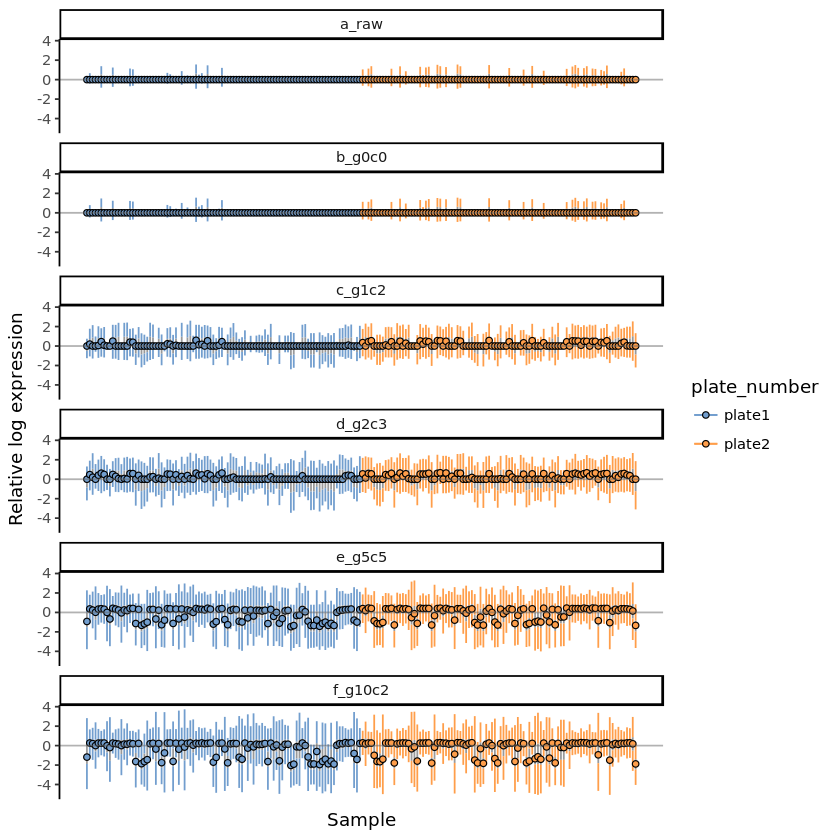

In [29]:
# CPM
plotRLE(
    sce,  # not used
    exprs_mats = list(
        a_raw  = logcounts(sce),
        b_g0c0 = logcounts(sce_g0c0),
        c_g1c2 = logcounts(sce_g1c2),
        d_g2c3 = logcounts(sce_g2c3),
        e_g5c5 = logcounts(sce_g5c5),
        f_g10c2= logcounts(sce_g10c2)
    ),
    exprs_logged = c(TRUE, TRUE, TRUE, TRUE, TRUE, TRUE),
    colour_by = "plate_number",
    order_by_color = FALSE
)


Warning message:
“Removed 1632 rows containing non-finite values (stat_density).”

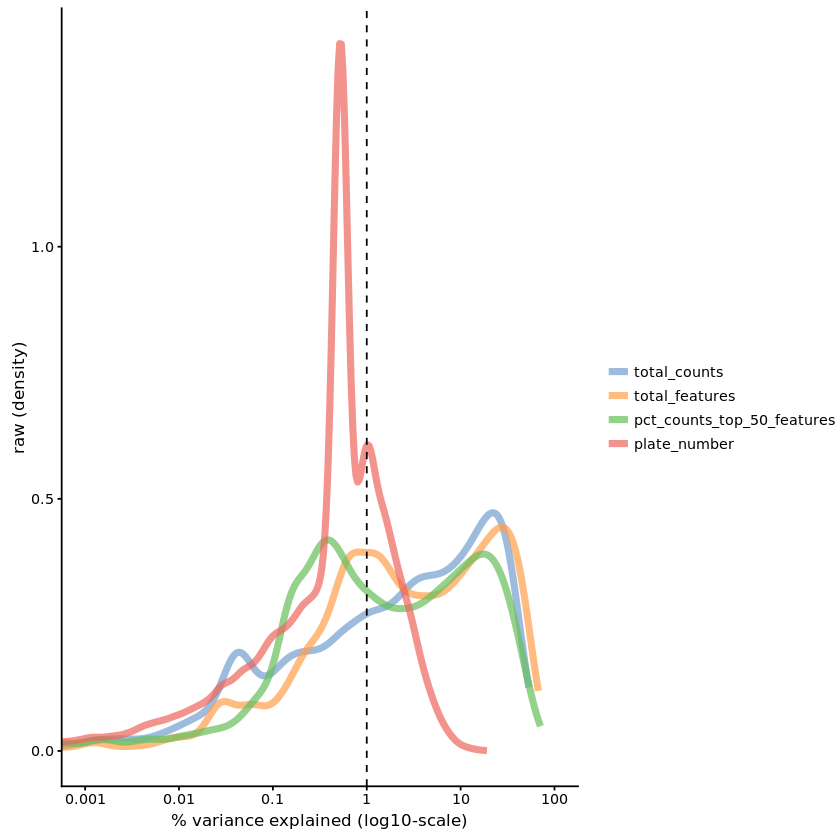

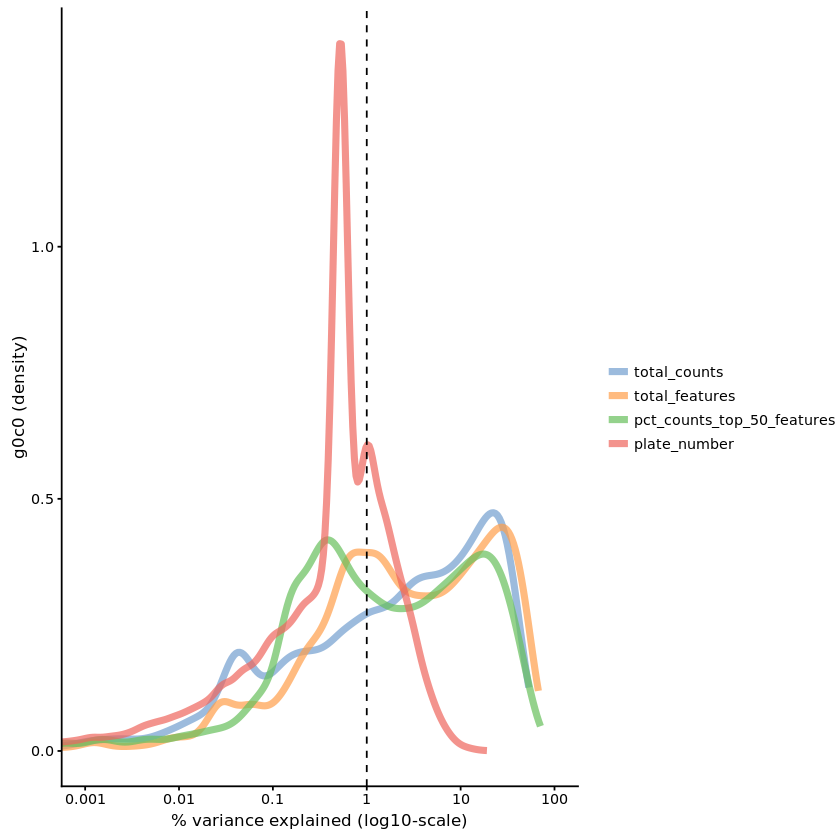

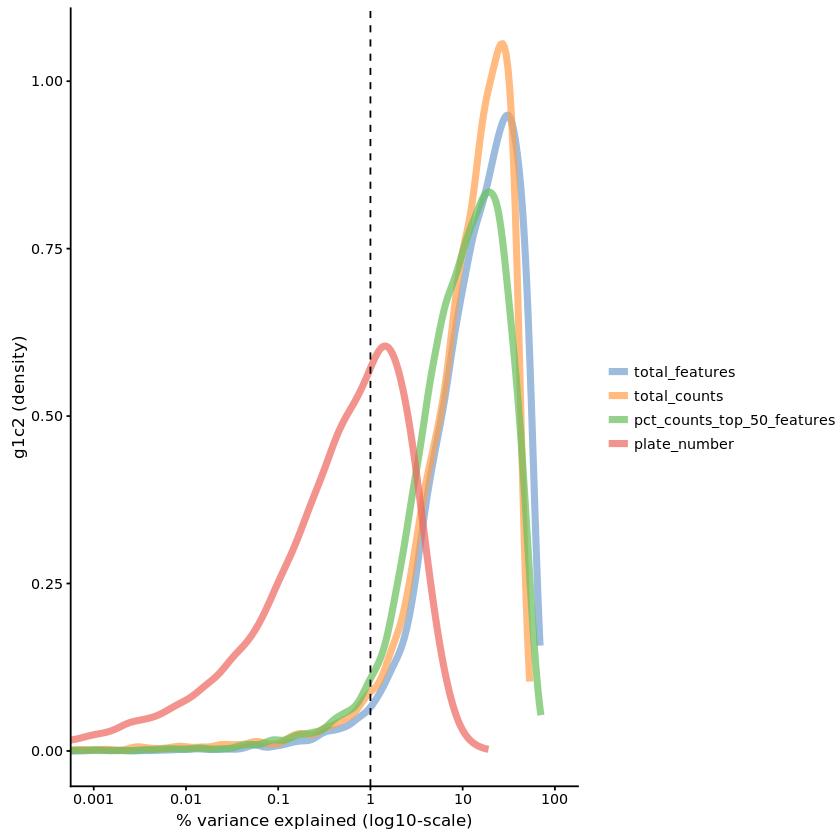

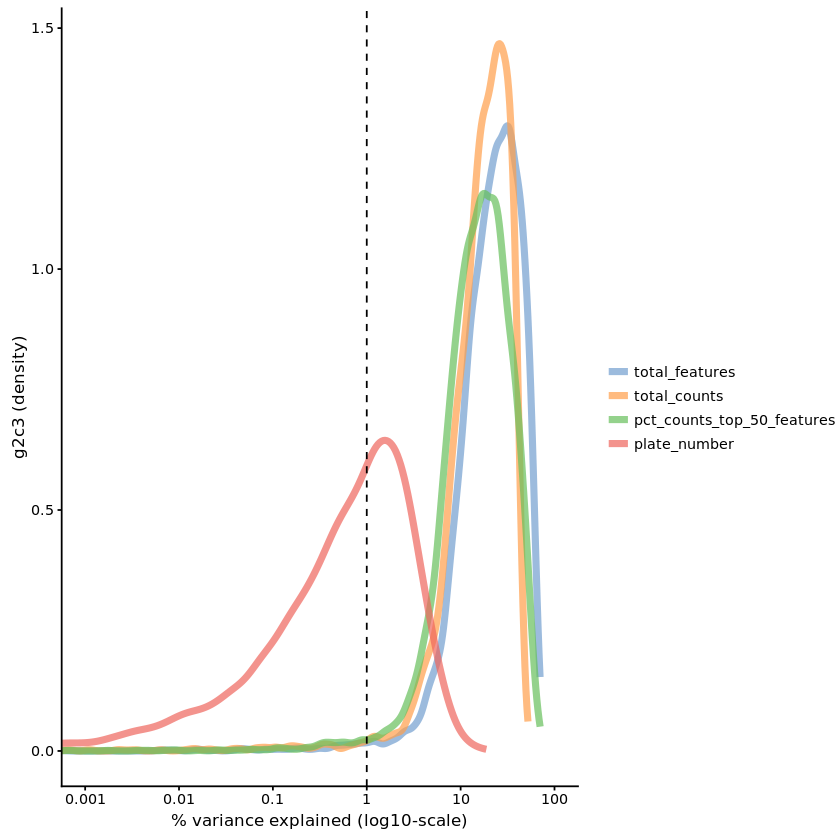

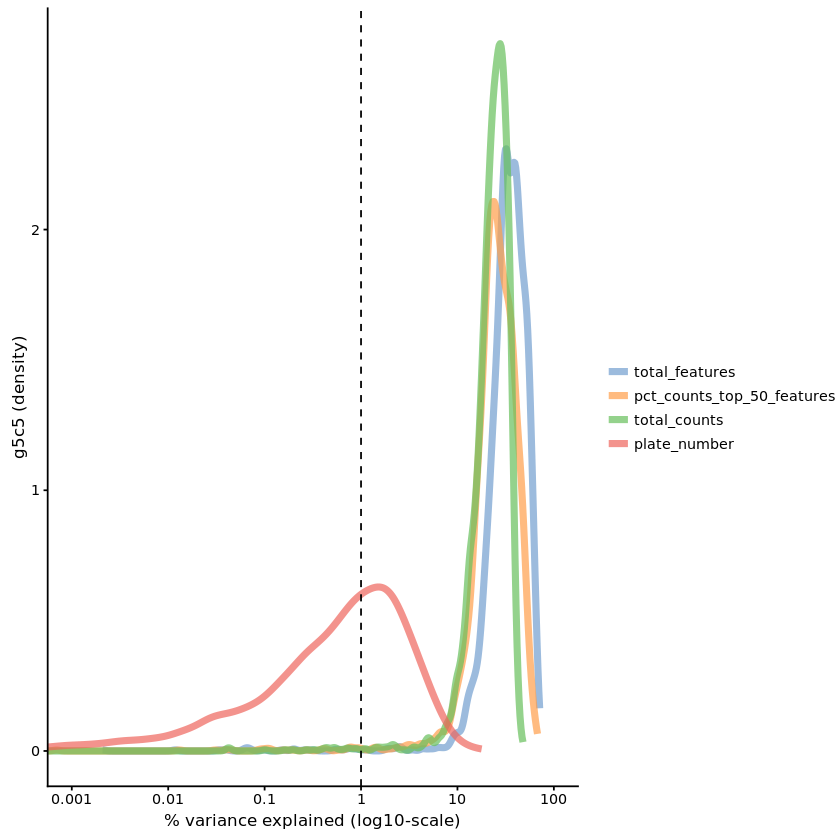

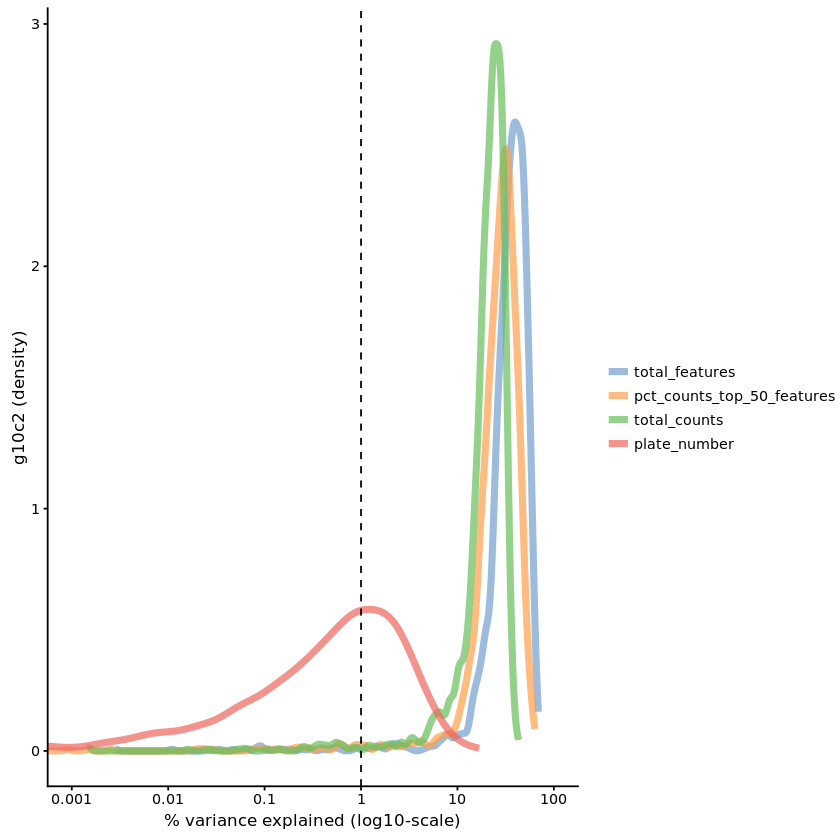

In [30]:
sce$namer = "raw"
sce_g0c0$namer = "g0c0"
sce_g1c2$namer = "g1c2"
sce_g2c3$namer = "g2c3"
sce_g5c5$namer = "g5c5"
sce_g10c2$namer = "g10c2"


for (mess in list(sce, sce_g0c0, sce_g1c2, sce_g2c3, sce_g5c5, sce_g10c2)){
    print(plotQC(mess, type = "expl", exprs_values = "logcounts",
            variables = c("total_features", "total_counts", "pct_counts_top_50_features", "plate_number")
    ) + ylab(paste(mess$namer, " (density)", sep="")))
}

The following selected_variables were not found in colData(object): pct_counts_feature_controlsThe following selected_variables were not found in colData(object): total_features_feature_controlsThe following selected_variables were not found in colData(object): log10_total_counts_endogenousThe following selected_variables were not found in colData(object): log10_total_counts_feature_controls
Other variables from colData(object) can be used by specifying a vector of variable names as the selected_variables argument.
PCA is being conducted using the following variables:pct_counts_top_100_featurestotal_features
The following selected_variables were not found in colData(object): pct_counts_feature_controlsThe following selected_variables were not found in colData(object): total_features_feature_controlsThe following selected_variables were not found in colData(object): log10_total_counts_endogenousThe following selected_variables were not found in colData(object): log10_total_counts_featur

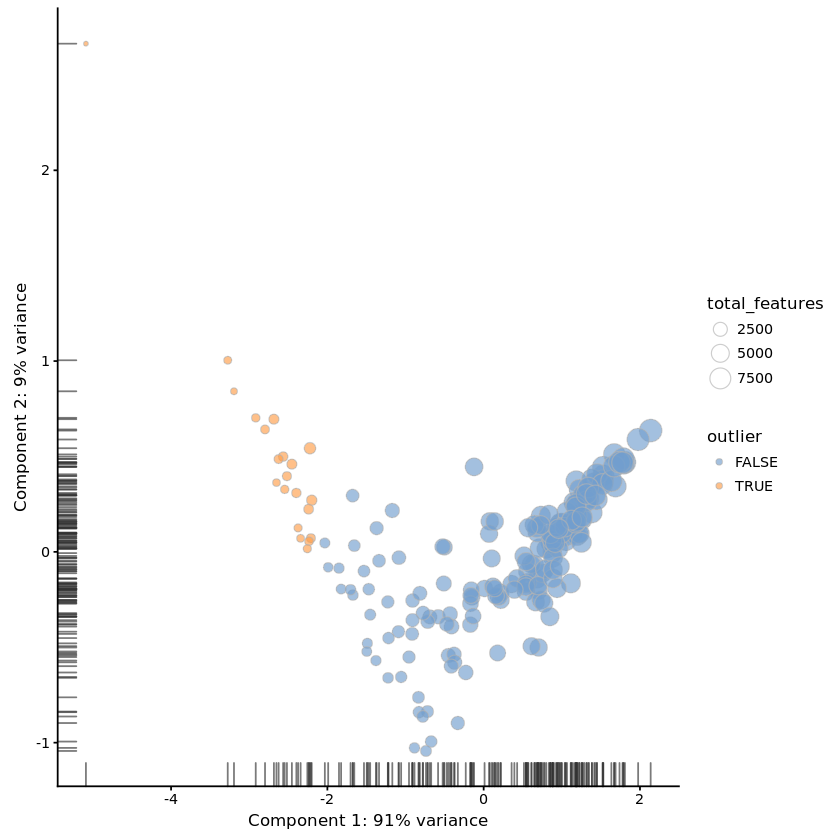

The following selected_variables were not found in colData(object): pct_counts_feature_controlsThe following selected_variables were not found in colData(object): total_features_feature_controlsThe following selected_variables were not found in colData(object): log10_total_counts_endogenousThe following selected_variables were not found in colData(object): log10_total_counts_feature_controls
Other variables from colData(object) can be used by specifying a vector of variable names as the selected_variables argument.
PCA is being conducted using the following variables:pct_counts_top_100_featurestotal_features


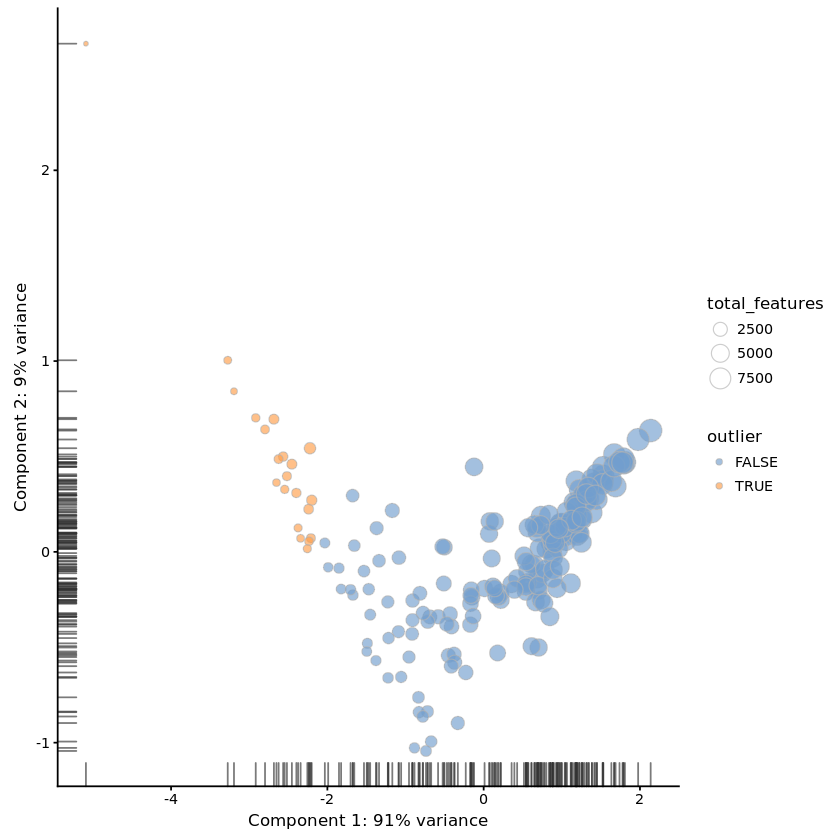

The following selected_variables were not found in colData(object): pct_counts_feature_controlsThe following selected_variables were not found in colData(object): total_features_feature_controlsThe following selected_variables were not found in colData(object): log10_total_counts_endogenousThe following selected_variables were not found in colData(object): log10_total_counts_feature_controls
Other variables from colData(object) can be used by specifying a vector of variable names as the selected_variables argument.
PCA is being conducted using the following variables:pct_counts_top_100_featurestotal_features


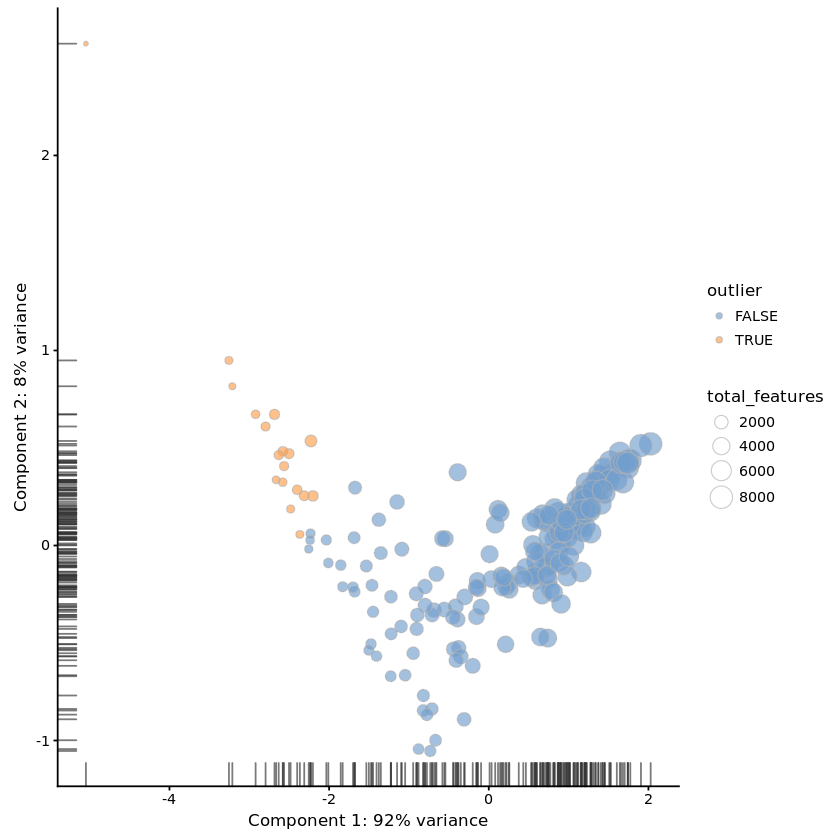

The following selected_variables were not found in colData(object): pct_counts_feature_controlsThe following selected_variables were not found in colData(object): total_features_feature_controlsThe following selected_variables were not found in colData(object): log10_total_counts_endogenousThe following selected_variables were not found in colData(object): log10_total_counts_feature_controls
Other variables from colData(object) can be used by specifying a vector of variable names as the selected_variables argument.
PCA is being conducted using the following variables:pct_counts_top_100_featurestotal_features


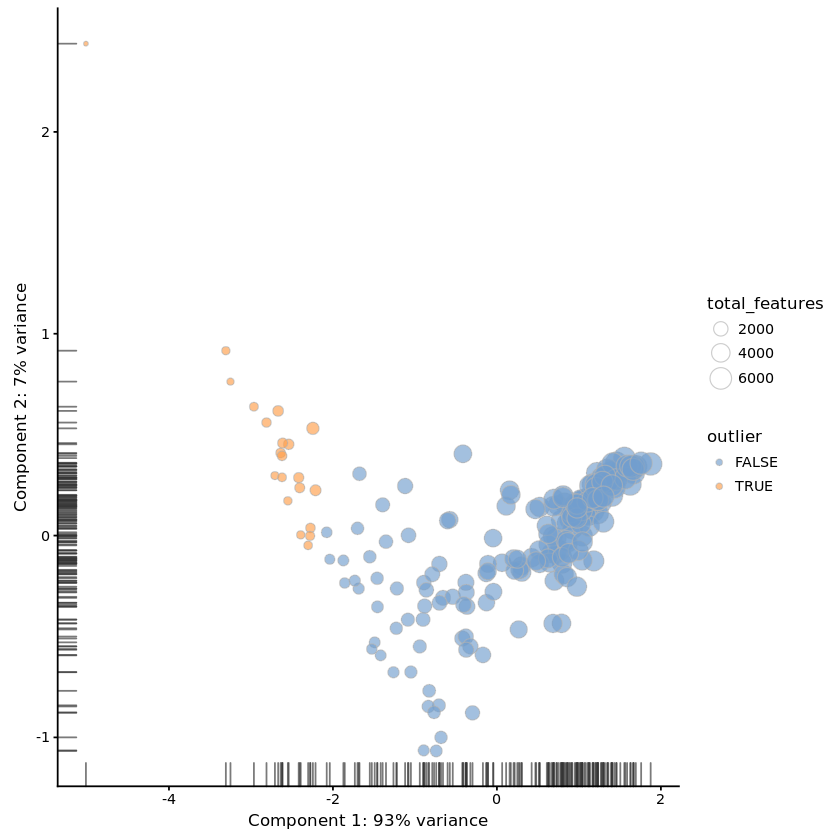

The following selected_variables were not found in colData(object): pct_counts_feature_controlsThe following selected_variables were not found in colData(object): total_features_feature_controlsThe following selected_variables were not found in colData(object): log10_total_counts_endogenousThe following selected_variables were not found in colData(object): log10_total_counts_feature_controls
Other variables from colData(object) can be used by specifying a vector of variable names as the selected_variables argument.
PCA is being conducted using the following variables:pct_counts_top_100_featurestotal_features


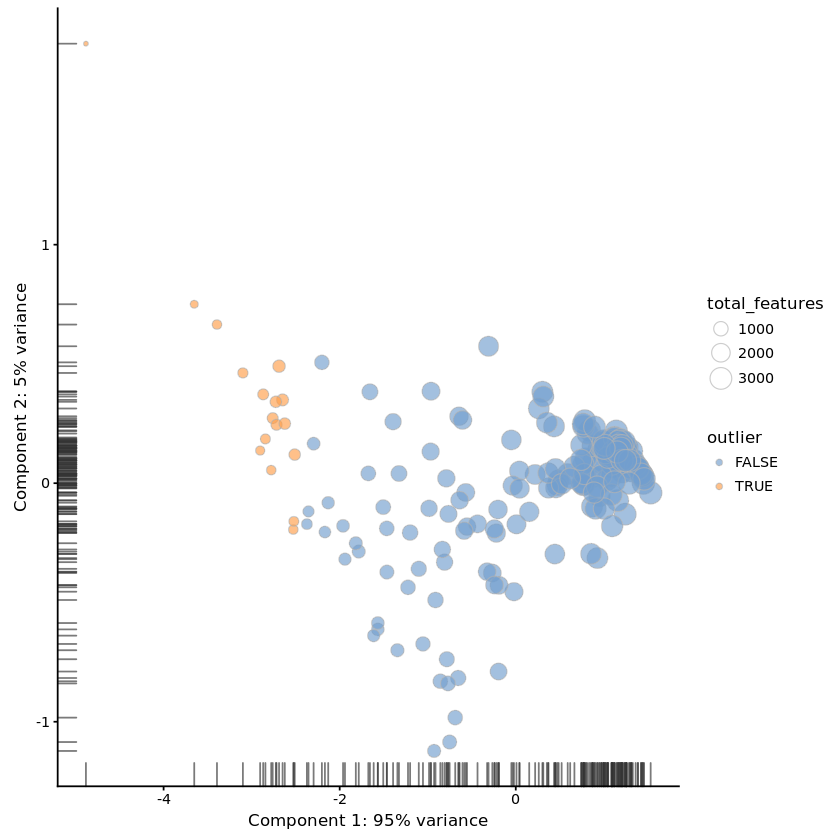

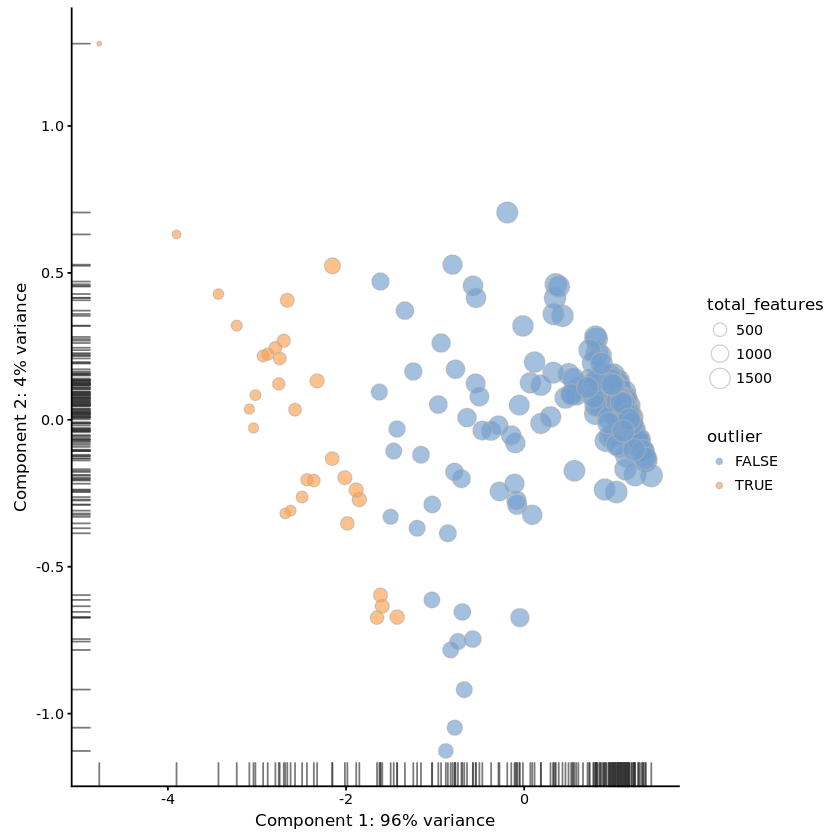

In [31]:
# Outlier detection

sce  <- plotPCA(sce, size_by = "total_features", detect_outliers = T, pca_data_input = "pdata", return_SCE = T)
sce_g0c0 <- plotPCA(sce_g0c0, size_by = "total_features", detect_outliers = T, pca_data_input = "pdata", return_SCE = T)
sce_g1c2 <- plotPCA(sce_g1c2, size_by = "total_features", detect_outliers = T, pca_data_input = "pdata", return_SCE = T)
sce_g2c3 <- plotPCA(sce_g2c3, size_by = "total_features", detect_outliers = T, pca_data_input = "pdata", return_SCE = T)
sce_g5c5 <- plotPCA(sce_g5c5, size_by = "total_features", detect_outliers = T, pca_data_input = "pdata", return_SCE = T)
sce_g10c2 <- plotPCA(sce_g10c2, size_by = "total_features", detect_outliers = T, pca_data_input = "pdata", return_SCE = T)



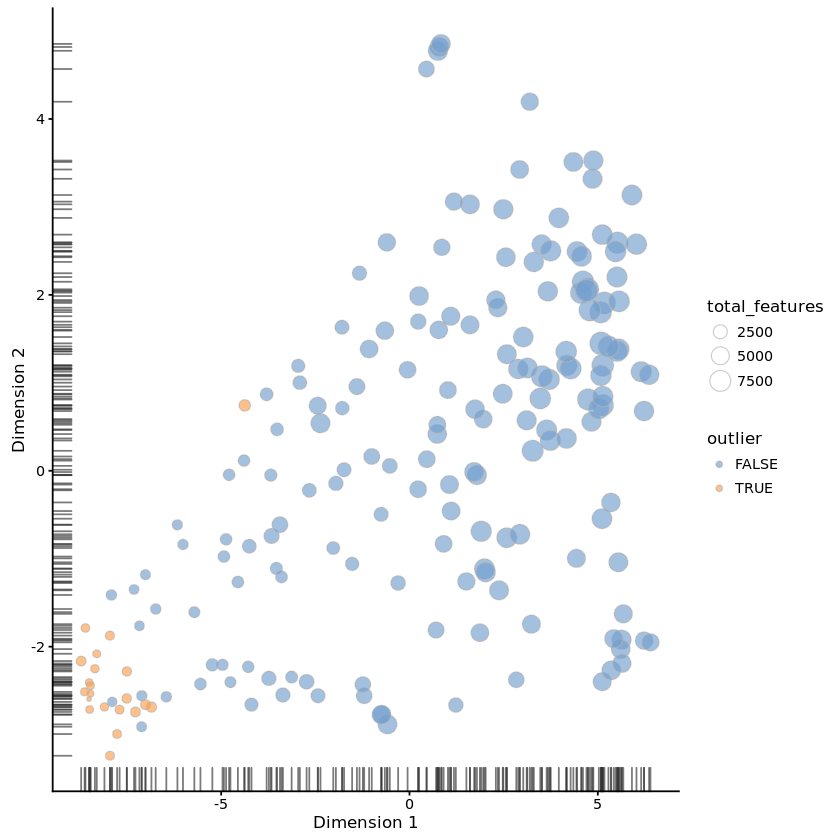

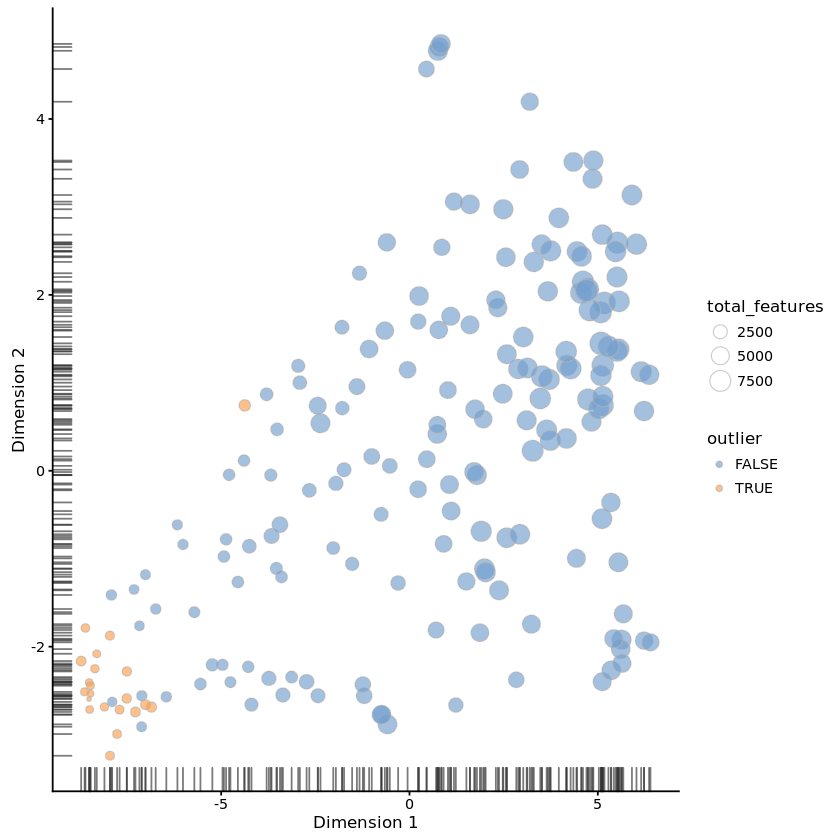

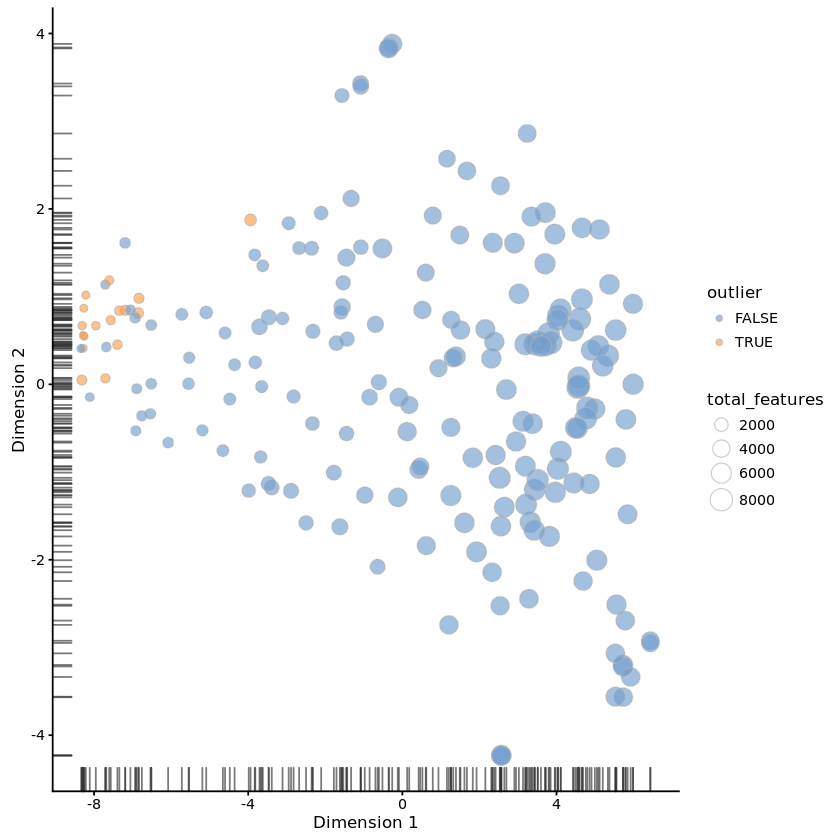

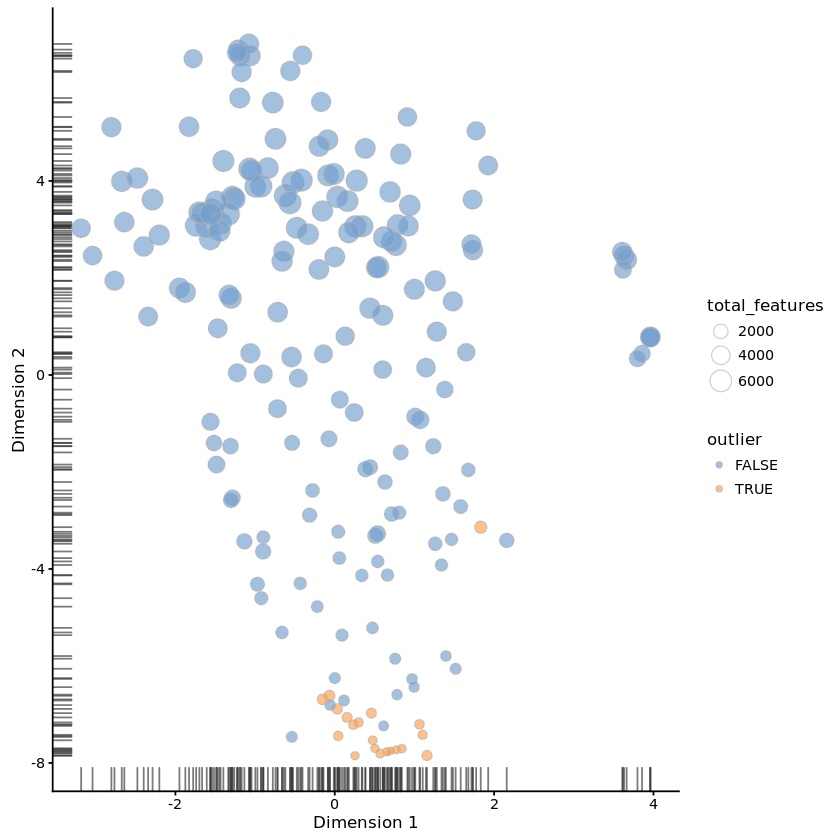

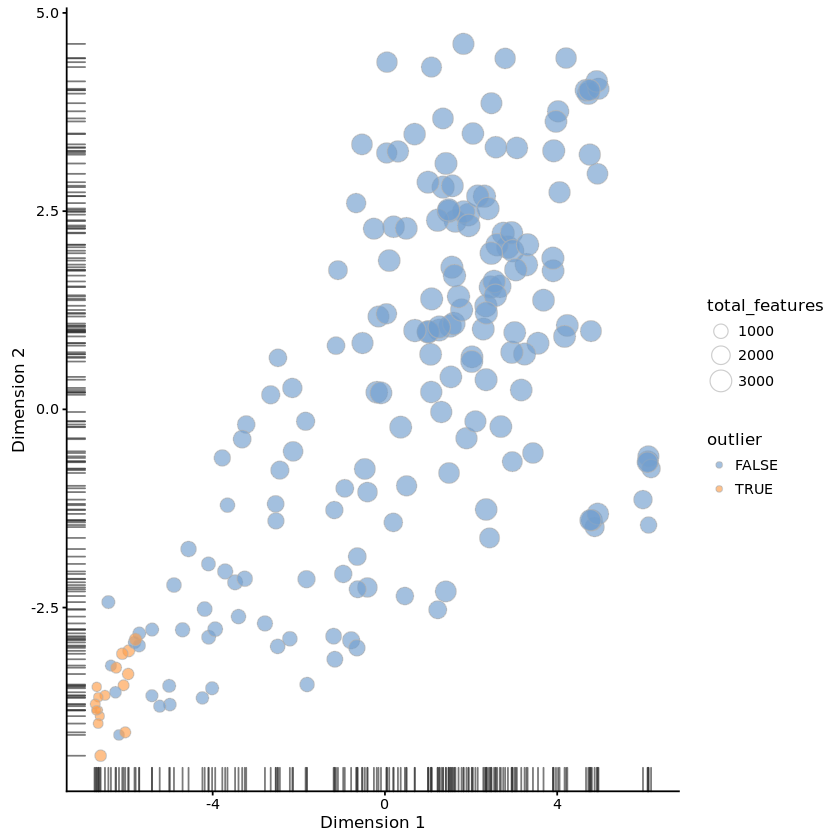

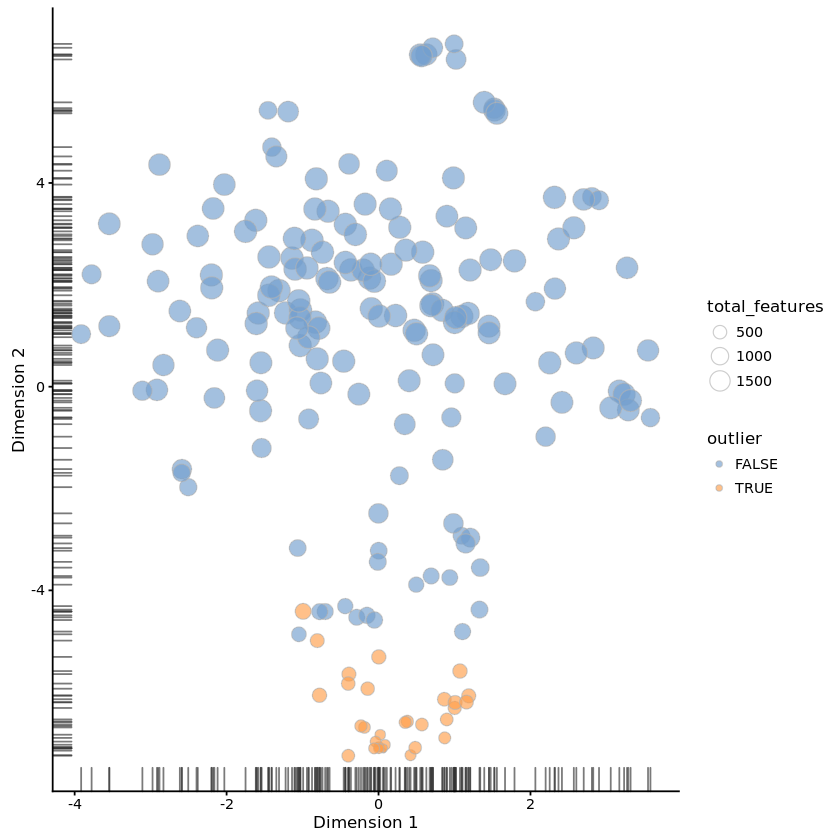

In [32]:
plotTSNE(sce, size_by = "total_features", colour_by = "outlier", rand = 90, exprs_values = "logcounts")
plotTSNE(sce_g0c0, size_by = "total_features", colour_by = "outlier", rand = 90, exprs_values = "logcounts")
plotTSNE(sce_g1c2, size_by = "total_features", colour_by = "outlier", rand = 90, exprs_values = "logcounts")
plotTSNE(sce_g2c3, size_by = "total_features", colour_by = "outlier", rand = 90, exprs_values = "logcounts")
plotTSNE(sce_g5c5, size_by = "total_features", colour_by = "outlier", rand = 90, exprs_values = "logcounts")
plotTSNE(sce_g10c2, size_by = "total_features", colour_by = "outlier", rand = 90, exprs_values = "logcounts")
